In [1]:
import numpy as np
import matplotlib.pyplot as plt
from project_utilities import init_mpl
from project_utilities import visualize_matrix as vis_mat
from optimal_transport import *
import time
from matplotlib import animation
from IPython.display import HTML
import io
import base64
import matplotlib as mpl

In [2]:
init_mpl(120)

# Calculating the cost matrix for higher dimensional inputs

Here we define the functions used to calculate the cost matrix $M$ for higher dimensional imput images. In our approach we calculate $M$ for flattened input images, which allows us to represent it as a matrix and more easily generalize our approach to higher dimensional input images. Our approach should work for all input dimensions as long as the input images are comparable, i.e. two matrices can be compared but not a vector and a matrix. In our implementation it is possible to cut a cost matrix for smaller input images from a cost matrix for larger ones, drastically speeding up the process. For this, one only needs to specify the input dimensions of the images used to make the initial large cost matrix to allow for a reshape to the higher dimensional form. This is needed for the cutting procedure. If this is not provided an initial matrix for cubic input images of the same dimensions is assumed. If one keeps the multidimensional shape of the cost matrix, i.e. without flattening it to a 2D matrix first, this is also not needed and detected by the cutting algorithm. The latter is useful when combining this with our pre-calculate cost matrix function, which we will introduce later. Here, __exponent__ is equal to $p$ in 

$$M_{ij,p} =  ||\mathbf{x}_i-\mathbf{y}_j||^p_2 \rightarrow \mathbf{M}_p.$$

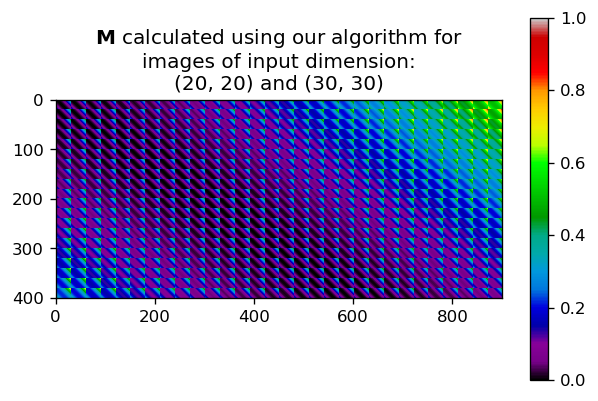

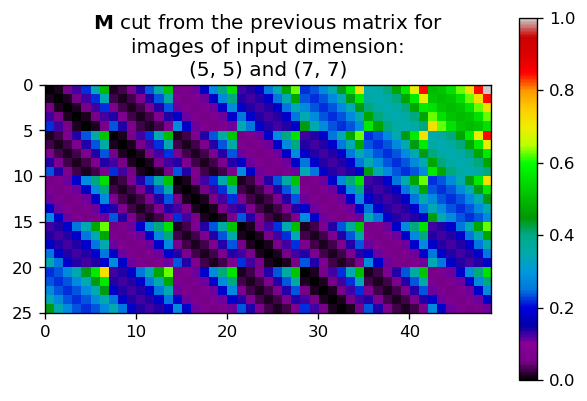

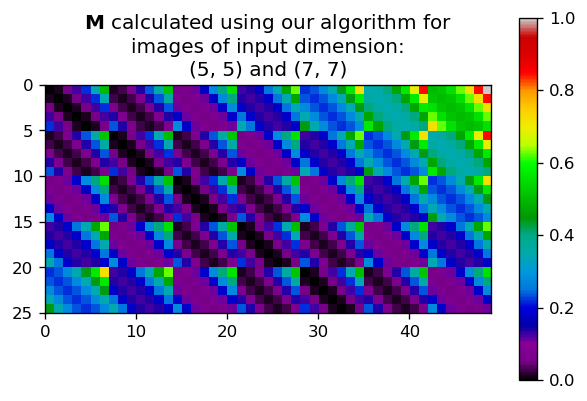

In [3]:
dim1_old = 20
dim2_old = 30
matrix1 = np.zeros((dim1_old,dim1_old))
matrix2 = np.zeros((dim2_old,dim2_old))
M = cost_matrix(matrix1,matrix2,exponent = 2,normalize = True)
vis_mat(M,plot = False)
plt.title('$\mathbf{M}$ calculated using our algorithm for\nimages of input dimension:\n' + str(matrix1.shape) + ' and ' + str(matrix2.shape))
plt.show()



dim1 = 5
dim2 = 7
matrix1 = np.zeros((dim1,dim1))
matrix2 = np.zeros((dim2,dim2))
M = cut_cost_matrix(matrix1,matrix2,M,old_shape = (dim1_old,dim1_old,dim2_old,dim2_old), normalize = True)
vis_mat(M,plot =False)
plt.title('$\mathbf{M}$ cut from the previous matrix for\nimages of input dimension:\n' + str(matrix1.shape) + ' and ' + str(matrix2.shape))



M = cost_matrix(matrix1,matrix2,exponent = 2 ,normalize = True)
vis_mat(M,plot = False)
plt.title('$\mathbf{M}$ calculated using our algorithm for\nimages of input dimension:\n' + str(matrix1.shape) + ' and ' + str(matrix2.shape))
plt.show()

__Observation:__ We show here that the cut matrix is indeed the same as the calculated matrix.

# 3D objects

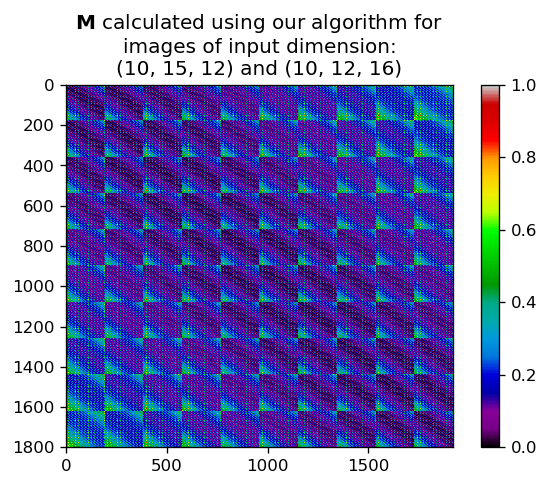

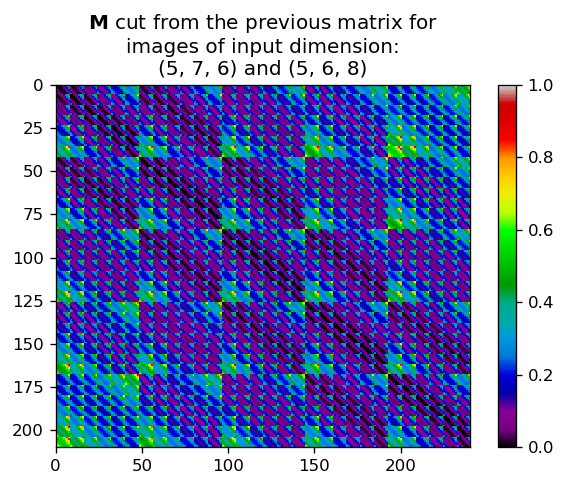

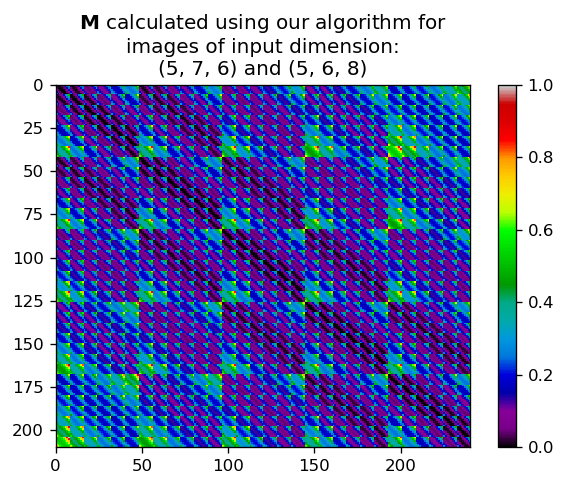

In [4]:
dim1_old = 10
dim2_old = 15
dim3_old = 12
dim4_old = 16
matrix1 = np.zeros((dim1_old,dim2_old,dim3_old))
matrix2 = np.zeros((dim1_old,dim3_old,dim4_old))
M = cost_matrix(matrix1,matrix2)
vis_mat(M,plot = False)
plt.title('$\mathbf{M}$ calculated using our algorithm for\nimages of input dimension:\n' + str(matrix1.shape) + ' and ' + str(matrix2.shape))
plt.show()



dim1 = 5
dim2 = 7
dim3 = 6
dim4 = 8
matrix1 = np.zeros((dim1,dim2,dim3))
matrix2 = np.zeros((dim1,dim3,dim4))
M = cut_cost_matrix(matrix1,matrix2,M,old_shape = (dim1_old,dim2_old,dim3_old,dim1_old,dim3_old,dim4_old))
vis_mat(M,plot =False)
plt.title('$\mathbf{M}$ cut from the previous matrix for\nimages of input dimension:\n' + str(matrix1.shape) + ' and ' + str(matrix2.shape))



M = cost_matrix(matrix1,matrix2)
vis_mat(M,plot = False)
plt.title('$\mathbf{M}$ calculated using our algorithm for\nimages of input dimension:\n' + str(matrix1.shape) + ' and ' + str(matrix2.shape))
plt.show()

__Observation:__ Also no problems for higher dimensional images.

# Wasserstein distance between two matrices using pre-calculated $\mathbf{M}$

We now introduce a function to pre-calculate a cost matrix. Using this we first pre-calculate a big cost matrix in its higher dimensional form, as opposed to the 2D representation used before. From this we can cut the smaller ones without having to reshape the initial matrix, since the matrix needs to be in its higher dimensional form to cut it. This is all taken care of in our functions by detecting the shape of the provided initial matrix and taking into account the dimensionality of $\mathbf{a}$ and $\mathbf{b}$. After obtaining the suitable cost matrix for the problem it is reshaped to a 2D matrix, also already taken care of withing our functions (both the cutting function and the Sinkhorn function can take care of this by correcting for the dimensionality of $\mathbf{a}$ and $\mathbf{b}$), which we can use in the Sinkhorn algorithm to find our minimizing $\boldsymbol{\gamma^*}$ for $\mathbf{a}$ and $\mathbf{b}$. The pre-calculated cost matrix is __not__ normalized by default, i.e.

$$\mathbf{M} \rightarrow  \frac{\mathbf{M}}{\max_{ij} (M_{ij})} $$

is __not__ done. The normalization is only done during the cutting step to minimize numerical errors.

## Summary of the procedure

Initialize big cost matrix for calculations. This is a multidimensional array (4D when comparing two matrices). 

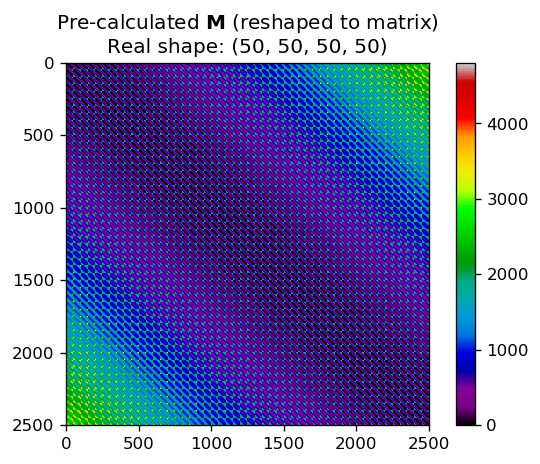

In [5]:
### precalculate cost matrix
precalc_dim = (50,50) 
exponent = 2
pre_calc = pre_calc_cost_matrix(precalc_dim ,precalc_dim ,exponent = exponent)
vis_mat(pre_calc.reshape((precalc_dim[0]**2,precalc_dim[0]**2)),plot = False) ## reshape needed to visualize
plt.title('Pre-calculated $\mathbf{M}$ (reshaped to matrix)\nReal shape: ' + str(pre_calc.shape))
plt.show()
######



Define and normalize $\mathbf{a}$ and $\mathbf{b}$, i.e.

$$\sum_i a_i = 1\text{, } \sum_i b_i = 1 \\ a_i,b_i \geq 0 \text{ } \forall i.$$

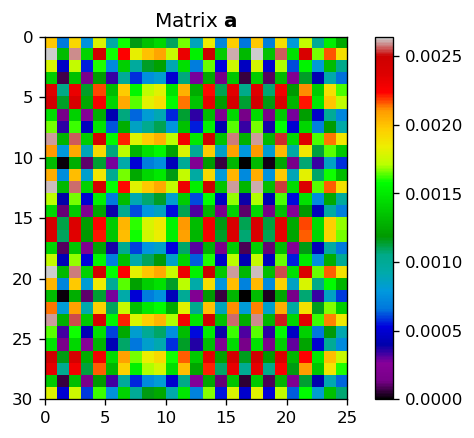

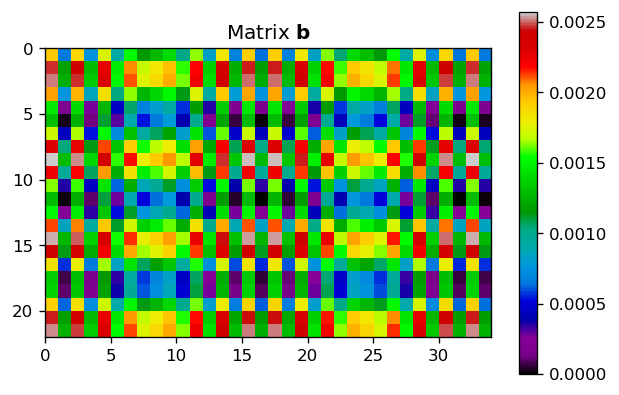

In [6]:
def funct(x,params):
    init = np.zeros((len(x[1]),len(x[0])))
    for i in range(len(x[1])):
        for j in range(len(x[0])):
            init[i,j] = np.sin(params[0]*x[1][i]) + np.cos(params[1]*x[0][j])
    return init

x = []
x.append(np.linspace(0,100,25))
x.append(np.linspace(0,100,30))
y = []
y.append(np.linspace(0,100,34))
y.append(np.linspace(0,100,22))

paramsa = [0.5,0.8]
paramsb = [20,30]

a = normalize_function(x,paramsa,funct)
b =normalize_function(y,paramsb,funct)
vis_mat(a,plot = False)
plt.title('Matrix $\mathbf{a}$')
plt.show()
vis_mat(b,plot = False)
plt.title('Matrix $\mathbf{b}$')
plt.show()




Finally, we run the Sinkhorn algorithm and obtain $\boldsymbol{\gamma^*}$ and $W_p^\lambda$ for the two matrices. Here __err_check__ determines the interval of iterations between which the error is not calculated (starting at 0), so the convergence is not checked in this interval. The Sinhorn function returns a tuple containing:

- 1. $\boldsymbol{\gamma^*}$
- 2. ($W_p^{\lambda})^p = (\sum_{ij}\gamma_{ij} M_{p,ij})$
- 3. Array containing the errors at each __err_check__ interval
- 4. Bool telling you if the solution has converged or not (__True__ for convergence)

Converged after 480 iterations (6.39955472946167 seconds)


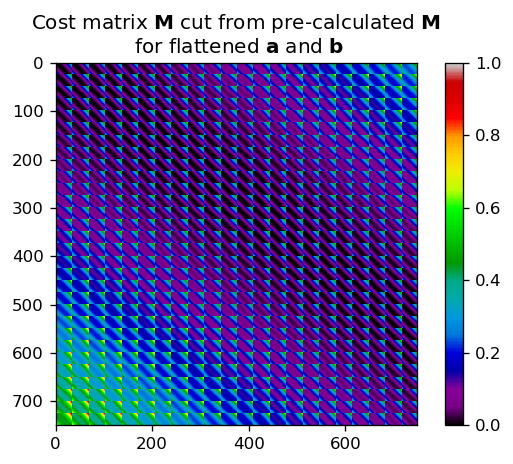

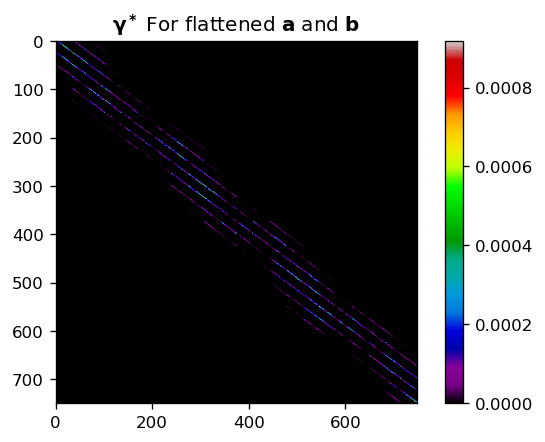

Wasserstein distance = 0.15424685607390062


In [7]:
M = cut_cost_matrix(a,b,pre_calc)
vis_mat(M, plot = False)
plt.title('Cost matrix $\mathbf{M}$ cut from pre-calculated $\mathbf{M}$\n for flattened $\mathbf{a}$ and $\mathbf{b}$')
data = sinkhorn(a,b,M,lambd = 0.001,maxiters = 10000, threshold = 10e-5,err_check = 10,verbose = True)
vis_mat(data[0], plot = False)
plt.title('$\mathbf{\gamma^*}$ For flattened $\mathbf{a}$ and $\mathbf{b}$')
plt.show()
print('Wasserstein distance = ' + str(data[1]**(1/2)))

# Speed difference between calculating the matrix and cutting the matrix

In [8]:
times = 2
data = {}
data['Calculated'] = []
data['Cut'] = []
CI = 1.96
orig_dims = (40,40)
orig = pre_calc_cost_matrix(orig_dims,orig_dims)
cache = []
dimsies = [5,10,15,20,25,30,35]
for dims in dimsies:
    M1 =np.zeros((dims,dims))
    M2 = np.zeros((dims,dims))
    cache = []
    for j in range(times):
        start = time.time()
        M = cost_matrix(M1,M2)
        cache.append(time.time()-start)
    data['Calculated'].append(cache)
    
for dims in dimsies:
    cache = []
    M1 =np.zeros((dims,dims))
    M2 = np.zeros((dims,dims))
    for j in range(times):
        start = time.time()
        M = cut_cost_matrix(M1,M2,orig)
        cache.append(time.time()-start)
    data['Cut'].append(cache)
    
for i in data:
    data[i] = np.array(data[i])

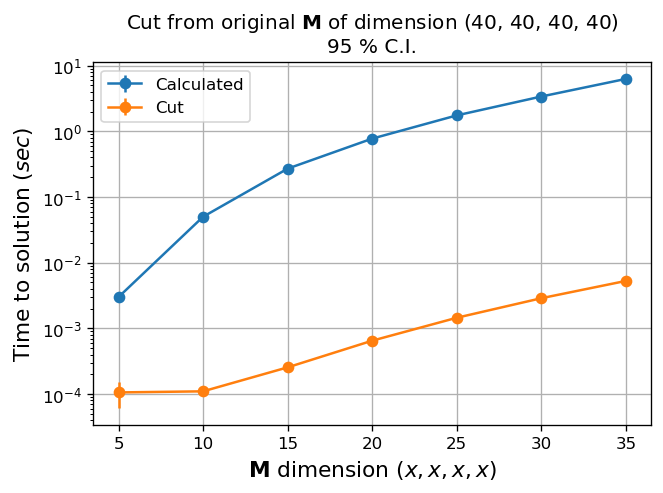

In [9]:
for i in data:
    plt.errorbar(np.array(dimsies),[np.average(i) for i in data[i]],yerr = [CI*np.std(i)/np.sqrt(len(i)) for i in data[i]], label = i, marker = 'o')
plt.legend()
plt.ylabel('Time to solution ($sec$)')
plt.xlabel('$\mathbf{M}$ dimension $(x, x, x, x)$')
plt.grid(True)
plt.title('Cut from original $\mathbf{M}$ of dimension ' + str(orig.shape)+ '\n95 % C.I.')
plt.yscale('log')
plt.show()

__Observation:__ We find that cutting the matrix from a pre-calculated one is much cheaper as compared to calculating it again.

# Animation transitioning from one image to the next using $\boldsymbol{\gamma^*}$

Only 2D input images are supported for the animation, however for all input dimensions transition images can be created and returned as a list.

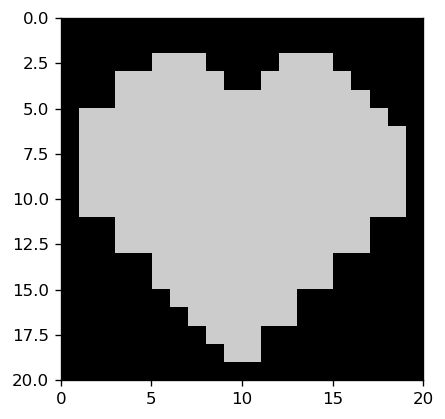

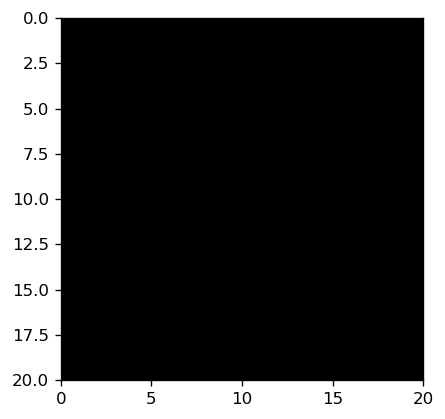

Converged after 310 iterations (0.11289691925048828 seconds)


In [10]:
a = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
b = np.ones(a.shape)
a = normalize_array(a)
b = normalize_array(b)
vis_mat(a,colorbar = False)
vis_mat(b, colorbar = False)
M = cost_matrix(a,b)
gamma = sinkhorn(a,b,M)[0]

In [6]:
name = 'Animation'
ot_movie(a,b,gamma,frames =100, name =name,save =False,animate = True)

Execution time: 95.36128568649292
Percentage of time spent on creating intermediate images: 93.77251841994956 %
Saved as: Animation.mp4


<Figure size 720x480 with 0 Axes>

In [7]:
video = io.open(name + '.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))